# Tabular Playground Series - February 2022

For this months TPS, we are predicting the class of bacteria based on the histogram of DNA bases found in 10-mers of the DNA segments. We are told that our data includes simulated measurement errors.

In [1]:
import pandas as pd
import numpy as np
import pyarrow

import time
import re
import math

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

In [ ]:
# Helper functions from https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/
from math import factorial
from random import choices, setstate
from collections import Counter
from itertools import product

# Function for downcasting float/int datatypes
def reduce_memory_usage(path):
    df = pd.read_csv(path);
    for col, dtype in df.dtypes.iteritems():
        if dtype.name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast ='integer')
        elif dtype.name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast ='float')
    return df

def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return bias(w, x, y, z)

def get_histograms(input_df):
    return pd.DataFrame({
        col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
    })

# Load Data

In [ ]:
# Training data
train = reduce_memory_usage('../data/train.csv')
features = [x for x in train.columns if x not in ['row_id','target']]

# Original Histograms

The training data is formed by creating histograms out of 10-mers, then subtracting off the "bias". The bias is the 10-mer count you would expect if you generated completely random DNA sequences. We then divide this unbiased count by the total number of 10-mers (1 million). Each row consists of different numbers of reads which are then multiplied by a constant so that their row sum is 1 million. 

In [ ]:
original = get_histograms(train[features])
original.describe()

# Quick Look

In [2]:
%%time
train = pd.read_feather('../data/train.feather')
features = [x for x in train.columns if x not in ['row_id', 'target']]

train[features].head()

Wall time: 228 ms


,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07
1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07
2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,-0.000007,...,0.000042,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06
3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,-0.000007,...,0.000068,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07
4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07


In [3]:
train[features].describe()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
count,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05
mean,6.419971e-07,-0.000003,-0.000014,-0.000010,0.000005,0.000025,0.000014,-0.000009,-0.000028,-0.000008,...,0.000135,0.000348,0.000253,0.000465,0.000581,0.000379,0.000062,8.980706e-05,1.169840e-04,2.214703e-07
std,8.653691e-05,0.000132,0.000287,0.000436,0.000683,0.000869,0.000775,0.000441,0.000107,0.000083,...,0.000711,0.001118,0.000914,0.001237,0.001528,0.001182,0.000466,5.478094e-04,6.786165e-04,2.048460e-05
min,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
25%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
50%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000237,-0.000199,-0.000114,-0.000043,-0.000010,...,0.000014,0.000064,0.000047,0.000124,0.000114,0.000043,-0.000010,4.632568e-07,4.632568e-07,-9.536743e-07
75%,-9.536743e-07,-0.000003,-0.000013,-0.000004,-0.000011,0.000003,-0.000030,0.000004,-0.000028,-0.000010,...,0.000111,0.000463,0.000297,0.000684,0.000774,0.000365,0.000030,6.046326e-05,6.946325e-05,-9.536743e-07
max,9.999046e-03,0.009990,0.009957,0.009886,0.019800,0.019760,0.019800,0.009886,0.009957,0.009990,...,0.019957,0.019914,0.019957,0.019914,0.019914,0.019957,0.009990,9.990463e-03,1.999046e-02,9.990464e-04


# Sanity Check

Since each row indicated a sequence of histograms, we should expect that the row sum should be roughly equal to 1. However, each observation is modified by subtracting off a bias term:

$$\textbf{bias}(A_wT_xG_yC_z) = \frac{1}{4^k} \cdot \frac{k!}{w!x!y!z!}$$

We recreate the original histograms and check that they add up to 1.

In [4]:
def bias(column_name):
    
    denom = 4**10
    denom *= math.factorial(int(re.search('(?<=A)\d+(?=T)', column_name).group(0)))
    denom *= math.factorial(int(re.search('(?<=T)\d+(?=G)', column_name).group(0)))
    denom *= math.factorial(int(re.search('(?<=G)\d+(?=C)', column_name).group(0)))
    denom *= math.factorial(int(re.search('(?<=C)\d+$', column_name).group(0)))
    
    return math.factorial(10) / denom

In [5]:
temp = np.zeros((len(train),))

for column in features:
    temp += train[column] + bias(column)

np.unique(temp)

array([0.99999998, 0.99999998, 0.99999998, ..., 1.00000001, 1.00000001,
       1.00000001])

It appears that any measurement errors introduced do not affect the rows summing to roughly to 1.

# Correlation

We should expect a good deal of correlation since in counting the 10-mers there should be a lot of overlap, since shifting left or right will change at most two values by one.

In [6]:
corr_matrix = train[features].corr()
np.fill_diagonal(corr_matrix.values, 0)

<AxesSubplot:>

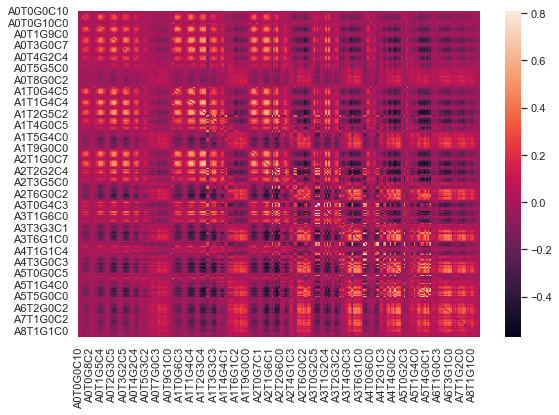

In [7]:

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr_matrix, ax=ax)

# Principal Components

We can look at the principal components explained variance to see the redundancy.

Text(0.5, 0, '# of Components')

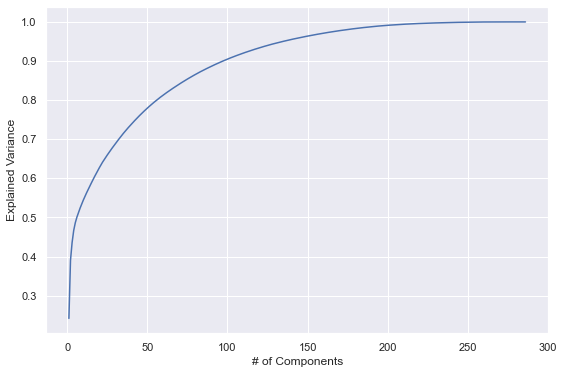

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(train[features])
cumsum = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize = (9,6))
ax.plot(range(1,len(cumsum)+1), cumsum)
plt.ylabel('Explained Variance')
plt.xlabel('# of Components')

# Base Frequencies

In [9]:
temp = train.drop('row_id', axis = 1).groupby('target').mean()

In [10]:
# Adenine (A)
df  = temp['A10T0G0C0'].to_frame()
df.columns = ['A10']
for i in range(9,-1,-1):
    df[f'A{i}'] = 0

for i in range(0,10):
    total = 0
    for column in temp.columns:
        assert len(df[f'A{i}']) == len(temp[column])
        if f'A{i}T' in column:
            df[f'A{i}'] += temp[column]
            total += 1
    if total > 0:
        df[f'A{i}'] /= total

In [11]:
# Cytosine (C)
df['C10']  = temp['A0T0G0C10']
for i in range(9,-1,-1):
    df[f'C{i}'] = 0

for i in range(0,10):
    total = 0
    for column in temp.columns:
        assert len(df[f'C{i}']) == len(temp[column])
        if f'C{i}' in column and column != 'A0T0G0C10':
            df[f'C{i}'] += temp[column]
            total += 1
    if total > 0:
        df[f'C{i}'] /= total

In [12]:
# Guanine (G)
df['G10'] = temp['A0T0G10C0']
for i in range(9,-1,-1):
    df[f'G{i}'] = 0

for i in range(0,10):
    total = 0
    for column in temp.columns:
        assert len(df[f'G{i}']) == len(temp[column])
        if f'G{i}' in column and column != 'A0T0G10C0':
            df[f'G{i}'] += temp[column]
            total += 1
    if total > 0:
        df[f'G{i}'] /= total

In [13]:
# Thymine (T)
df['T10'] = temp['A0T10G0C0']
for i in range(9,-1,-1):
    df[f'T{i}'] = 0

for i in range(0,10):
    total = 0
    for column in temp.columns:
        assert len(df[f'T{i}']) == len(temp[column])
        if f'T{i}' in column and column != 'A0T10G0C0':
            df[f'T{i}'] += temp[column]
            total += 1
    if total > 0:
        df[f'T{i}'] /= total

<AxesSubplot:ylabel='target'>

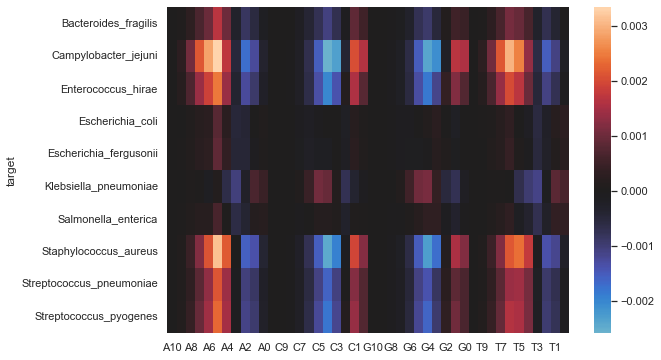

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df, center = 0, ax=ax)